<h2 align=center> Fine-Tune BERT for Text Classification with TensorFlow</h2>

In [1]:
import tensorflow as tf

In [2]:
!git clone --depth 1 -b v2.3.0 https://github.com/tensorflow/models.git

Cloning into 'models'...
remote: Enumerating objects: 2650, done.
remote: Counting objects: 100% (2650/2650), done.
remote: Compressing objects: 100% (2311/2311), done.
remote: Total 2650 (delta 505), reused 1389 (delta 306), pack-reused 0
Receiving objects: 100% (2650/2650), 34.02 MiB | 22.29 MiB/s, done.
Resolving deltas: 100% (505/505), done.
Note: switching to '400d68abbccda2f0f6609e3a924467718b144233'.

You are in 'detached HEAD' state. You can look around, make experimental
changes and commit them, and you can discard any commits you make in this
state without impacting any branches by switching back to a branch.

If you want to create a new branch to retain commits you create, you may
do so (now or later) by using -c with the switch command. Example:

  git switch -c <new-branch-name>

Or undo this operation with:

  git switch -

Turn off this advice by setting config variable advice.detachedHead to false



After running the following cell restart runtime

In [3]:
# install requirements to use tensorflow/models repository
!pip install -Uqr models/official/requirements.txt

# restart the runtime afterwards

  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 49.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 238.5/238.5 kB 28.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.2/18.2 MB 47.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.0/13.0 MB 60.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 288.2/288.2 kB 21.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 38.6/38.6 MB 12.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 27.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.1/5.1 MB 21.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 52.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.3/1.3 MB 75.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 97.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.9/49.9 MB 11.9 MB

After Restating runtime, run only below cells

In [1]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import sys
sys.path.append('models')

#Import bert modules
from official.nlp.data import classifier_data_lib
from official.nlp.bert import tokenization
from official.nlp import optimization

/usr/local/lib/python3.10/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


In [3]:
#Load the dataset

df = pd.read_csv('/content/spam.csv', encoding='latin-1')
df.shape

(5572, 5)

In [4]:
df.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [5]:
#drop columns 2, 3, 4
df.drop(columns={'Unnamed: 2', 'Unnamed: 3', 'Unnamed: 4'}, inplace = True)

In [6]:
#Rename column 1 an Class and column 2 as SMS
df.rename(columns= {'v1':'Class', 'v2':'SMS'}, inplace=True )
df.sample(5)

,Class,SMS
5215,ham,I keep ten rs in my shelf:) buy two egg.
285,ham,"K, I might come by tonight then if my class le..."
5255,ham,Ok... Sweet dreams...
4707,ham,"Did you say bold, then torch later. Or one tor..."
606,spam,XCLUSIVE@CLUBSAISAI 2MOROW 28/5 SOIREE SPECIAL...


In [7]:
#Replace ham with 0 and spam with 1
df['Class'] = df['Class'].replace(['ham', 'spam'], [0, 1])

<ipython-input-7-7453e64b1986>:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['Class'] = df['Class'].replace(['ham', 'spam'], [0, 1])


In [8]:
#drop duplicates
df = df.drop_duplicates(keep = 'first')

In [9]:
#Split the data into train and validation

train_df, remaining = train_test_split(df, random_state=42, train_size=0.8, stratify=df.Class.values)
valid_df, _ = train_test_split(remaining, random_state=42, train_size=0.5, stratify=remaining.Class.values)
train_df.shape, valid_df.shape

((4135, 2), (517, 2))

In [10]:
#Implementing the input pipeline

train_data = tf.data.Dataset.from_tensor_slices((train_df['SMS'].values, train_df['Class'].values))
valid_data = tf.data.Dataset.from_tensor_slices((valid_df.SMS.values, valid_df.Class.values))

#Check the data
for text, label in train_data.take(1):
  print(text)
  print(label)

tf.Tensor(b'Cool. So how come you havent been wined and dined before?', shape=(), dtype=string)
tf.Tensor(0, shape=(), dtype=int64)


In [11]:
#Set up hyper-parameters

label_list = [0, 1]                 # Label categories
max_seq_length = 128                # maximum length of (token) input sequences
train_batch_size = 32               # batch size for training

In [12]:
#import BERT from tensorflow hub

bert_layer = hub.KerasLayer('https://tfhub.dev/tensorflow/bert_en_uncased_L-12_H-768_A-12/2', trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

Implementing a function to convert the text data into the BERT format

In [13]:
def convert_text_to_feature(text, label, label_list=label_list, max_seq_length=max_seq_length, tokenizer=tokenizer):
    example = classifier_data_lib.InputExample(guid=None,
                                               text_a=text.numpy().decode(),
                                               text_b=None,
                                               label=label.numpy())

    feature = classifier_data_lib.convert_single_example(0, example, label_list, max_seq_length, tokenizer)

    return (feature.input_ids, feature.input_mask, feature.segment_ids, feature.label_id)


In [14]:
def to_map(text, label):
    input_ids, input_mask, segment_ids, label_id = tf.py_function(convert_text_to_feature, inp=[text, label], Tout=[tf.int32, tf.int32, tf.int32, tf.int32])

    input_ids.set_shape([max_seq_length])
    input_mask.set_shape([max_seq_length])
    segment_ids.set_shape([max_seq_length])
    label_id.set_shape([])

    x = {
        'input_word_ids': input_ids,
        'input_mask': input_mask,
        'input_type_ids': segment_ids
    }

    return (x, label_id)

In [15]:
train_data = (train_data.map(to_map,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
                            .shuffle(1000)
                            .batch(32, drop_remainder=True)
                            .prefetch(tf.data.experimental.AUTOTUNE))


valid_data = (valid_data.map(to_map,
                             num_parallel_calls=tf.data.experimental.AUTOTUNE)
                            .batch(32, drop_remainder=True)
                            .prefetch(tf.data.experimental.AUTOTUNE))


In [16]:
#Check the data
train_data.take(1)

<_TakeDataset element_spec=({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None), 'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)}, TensorSpec(shape=(32,), dtype=tf.int32, name=None))>

In [17]:
# train data spec
train_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

In [18]:
# valid data spec
valid_data.element_spec

({'input_word_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_mask': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None),
  'input_type_ids': TensorSpec(shape=(32, 128), dtype=tf.int32, name=None)},
 TensorSpec(shape=(32,), dtype=tf.int32, name=None))

Create the model

In [19]:
# Building the model
def create_model():
  input_word_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                         name='input_word_ids')

  input_mask = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                         name='input_mask')

  input_type_ids = tf.keras.layers.Input(shape=(max_seq_length, ), dtype=tf.int32,
                                         name='input_type_ids')

  pooled_output, sequence_output = bert_layer([input_word_ids, input_mask, input_type_ids])

  drop = tf.keras.layers.Dropout(0.4)(pooled_output)
  output = tf.keras.layers.Dense(1, activation = 'sigmoid', name='output')(drop)

  model = tf.keras.Model(
      inputs = {
          'input_word_ids': input_word_ids,
          'input_mask': input_mask,
          'input_type_ids': input_type_ids
      },
      outputs = output)

  return model

In [20]:
model = create_model()
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=2e-5),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=[tf.keras.metrics.BinaryAccuracy()])

model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_word_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                                  
 input_mask (InputLayer)     [(None, 128)]                0         []                            
                                                                                                  
 input_type_ids (InputLayer  [(None, 128)]                0         []                            
 )                                                                                                
                                                                                              

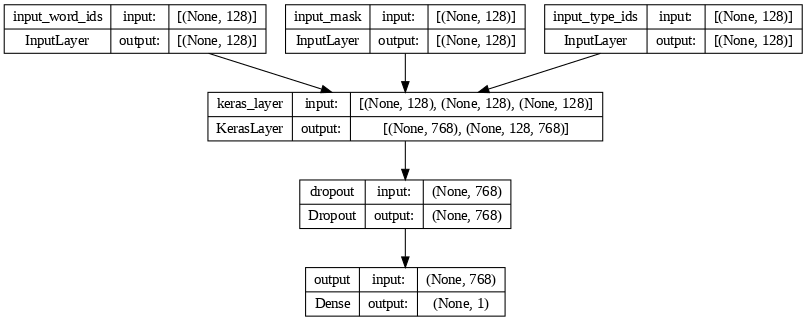

In [21]:
tf.keras.utils.plot_model(model=model, show_shapes=True, dpi = 76)

Train the model

In [22]:
epochs = 5
history = model.fit(train_data,
                    validation_data = valid_data,
                    epochs = epochs,
                    verbose=1)

Epoch 1/5
129/129 [==============================] - 154s 844ms/step - loss: 0.1550 - binary_accuracy: 0.9387 - val_loss: 0.0332 - val_binary_accuracy: 0.9902
Epoch 2/5
129/129 [==============================] - 112s 858ms/step - loss: 0.0211 - binary_accuracy: 0.9937 - val_loss: 0.0561 - val_binary_accuracy: 0.9883
Epoch 3/5
129/129 [==============================] - 112s 858ms/step - loss: 0.0103 - binary_accuracy: 0.9966 - val_loss: 0.0582 - val_binary_accuracy: 0.9883
Epoch 4/5
129/129 [==============================] - 111s 856ms/step - loss: 0.0098 - binary_accuracy: 0.9971 - val_loss: 0.0412 - val_binary_accuracy: 0.9883
Epoch 5/5
129/129 [==============================] - 111s 856ms/step - loss: 0.0018 - binary_accuracy: 0.9998 - val_loss: 0.0680 - val_binary_accuracy: 0.9883


Plot the Model Training Status

In [23]:
import matplotlib.pyplot as plt

def plot_graphs(history, metric):
  plt.plot(history.history[metric])
  plt.plot(history.history['val_'+metric], '')
  plt.xlabel("Epochs")
  plt.ylabel(metric)
  plt.legend([metric, 'val_'+metric])
  plt.show()

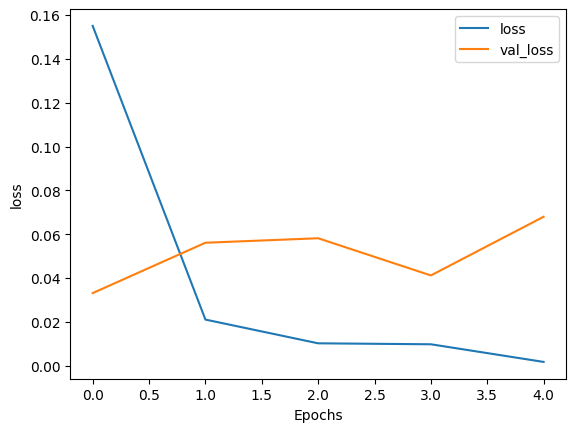

In [24]:
#plot the model loss
plot_graphs(history, 'loss')

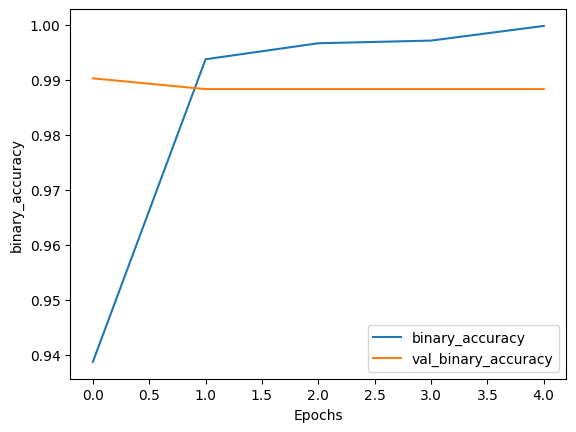

In [25]:
#Plot the model accuracy
plot_graphs(history, 'binary_accuracy')

##Evaluating Model Performance

Plot the confusion matrix for training dataset

In [42]:
true_labels_train = train_df['Class'].to_list()

In [44]:
train_data_list = train_df['SMS'].to_list()
test_data_train = tf.data.Dataset.from_tensor_slices((train_data_list, [0]*len(train_data_list)))
test_data_train = (test_data_train.map(to_map).batch(1))
preds = model.predict(test_data_train)

4135/4135 [==============================] - 64s 15ms/step


In [45]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

/usr/local/lib/python3.10/dist-packages/seaborn/_base.py:949: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


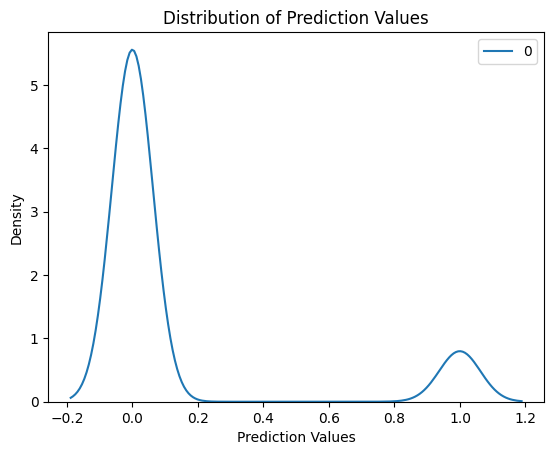

In [46]:
#Plot the prediction values distribution

sns.kdeplot(preds)
plt.xlabel("Prediction Values")
plt.ylabel("Density")
plt.title("Distribution of Prediction Values")
plt.show()

It is able to use threshold value as 0.5 due to good classification

In [47]:
threshold = 0.5

In [48]:
#convert prediction labels into 0 and 1

predicted_labels_train = np.where(preds >= threshold, 1, 0)
predicted_labels_train = predicted_labels_train.tolist()

In [49]:
print(len(true_labels_train), len(predicted_labels_train))

4135 4135


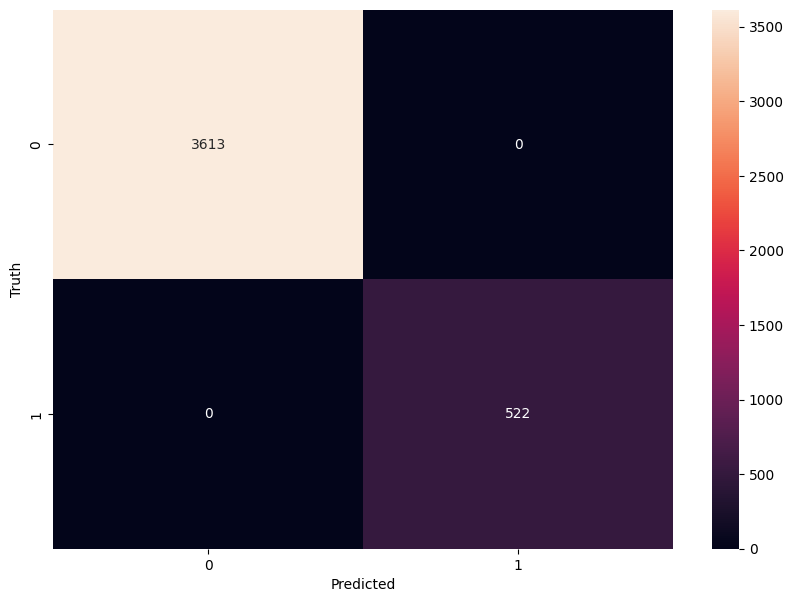

In [50]:
#plot confusion matrix as heatmap

from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(true_labels_train, predicted_labels_train)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Plot the confusion matrix for validation dataset

In [51]:
true_labels_val = valid_df['Class'].to_list()

In [53]:
valid_data_list = valid_df['SMS'].to_list()
test_data_val = tf.data.Dataset.from_tensor_slices((valid_data_list, [0]*len(valid_data_list)))
test_data_val = (test_data_val.map(to_map).batch(1))
preds_val = model.predict(test_data_val)

517/517 [==============================] - 7s 14ms/step


In [54]:
#convert prediction labels into 0 and 1

predicted_labels_val = np.where(preds_val >= 0.5, 1, 0)
predicted_labels_val = predicted_labels_val.tolist()

In [55]:
print(len(true_labels_val), len(predicted_labels_val))

517 517


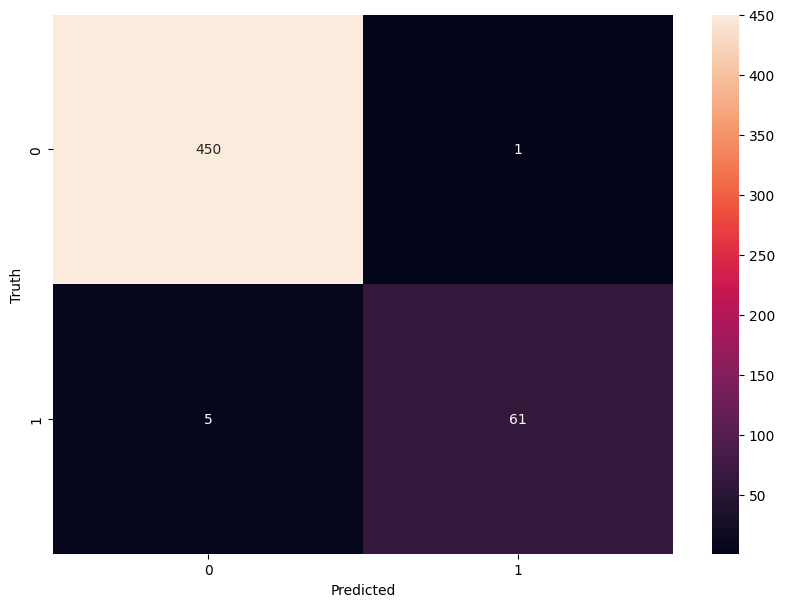

In [56]:
from sklearn.metrics import confusion_matrix

# Create a confusion matrix
cm = confusion_matrix(true_labels_val, predicted_labels_val)

# Create a heatmap
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d')
plt.xlabel('Predicted')
plt.ylabel('Truth')

plt.show()

Testing model using random example

In [57]:
text_sample = ['Congratulations! You’ve won a $500 gift card to Target. Click here to claim your reward']
test_data_sample = tf.data.Dataset.from_tensor_slices((text_sample, [0]*len(text_sample)))
test_data_sample = (test_data_sample.map(to_map).batch(1))
preds = model.predict(test_data_sample)

['Spam' if pred >= threshold else 'ham' for pred in preds]

1/1 [==============================] - 0s 33ms/step


['Spam']